# Deltatorch Example
This notebook briefly demonstrates how to use the [deltatorch](https://github.com/delta-incubator/deltatorch) python library to use `DeltaLake` tables as a data source for model training using PyTorch. The deltatorch library allows users to create a PyTorch `DataLoader` from a DeltaLake dataset.

In this end-to-end example, we'll create a `DataLoader` from a Delta Lake table containing the MNIST dataset, and use it to train a PyTorch CNN model. The `deltatorch` library enables creating PyTorch `DataLoader`s directly from Delta Lake tables, avoiding any conversion to Pandas/NumPy. This allows efficient, scalable data loading from Delta Lake into PyTorch.

## Installation

In [1]:
%pip install git+https://github.com/delta-incubator/deltatorch

  Cloning https://github.com/delta-incubator/deltatorch to /private/var/folders/m_/nbhhpg550yl539yhlgch8qqr0000gp/T/pip-req-build-xss6efwr
  Running command git clone --filter=blob:none --quiet https://github.com/delta-incubator/deltatorch /private/var/folders/m_/nbhhpg550yl539yhlgch8qqr0000gp/T/pip-req-build-xss6efwr
  Resolved https://github.com/delta-incubator/deltatorch to commit 4346c313dc194b1222cbc799ce386776fd964120
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyspark
from delta import *

builder = pyspark.sql.SparkSession.builder.appName("deltatorch-example") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.executor.memory", "8g")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

:: loading settings :: url = jar:file:/Users/daniel.liden/git/delta-examples/env/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/daniel.liden/.ivy2/cache
The jars for the packages stored in: /Users/daniel.liden/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9e882e8a-9d50-4348-9975-1be8001acebb;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.4.0 in central
	found io.delta#delta-storage;2.4.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 74ms :: artifacts dl 3ms
	:: modules in use:
	io.delta#delta-core_2.12;2.4.0 from central in [default]
	io.delta#delta-storage;2.4.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   

## Get some Data
To provide an example with real data, we'll download the `mnist` dataset and save it as a Delta Lake.

In [3]:
from torchvision import datasets
from pyspark.sql.types import IntegerType, StructType, StructField, FloatType, BinaryType
import numpy as np

In [4]:
train_set = datasets.MNIST(root='./data', train=True, download=True)
test_set = datasets.MNIST(root='./data', train=False, download=True)

# Convert the data to a Spark DataFrame
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("label", FloatType(), False),
    StructField("features", BinaryType(), False)  # Changed ArrayType(IntegerType()) to BinaryType()
])

# Convert images to numpy arrays and save as binary
train_data = [(i, float(y), bytearray(np.array(x))) for i, (x, y) in enumerate(train_set)]
train_df = spark.createDataFrame(train_data, schema).repartition(50)

test_data = [(i, float(y), bytearray(np.array(x))) for i, (x, y) in enumerate(test_set)]
test_df = spark.createDataFrame(test_data, schema).repartition(50)

# Write the DataFrame to Delta Lake format
train_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("./data/mnist_delta/train")
test_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("./data/mnist_delta/test")


23/07/20 08:06:43 WARN TaskSetManager: Stage 1 contains a task of very large size (3239 KiB). The maximum recommended task size is 1000 KiB.
23/07/20 08:06:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/07/20 08:06:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/07/20 08:06:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
23/07/20 08:06:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
23/07/20 08:06:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
23/07/20 08:06:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,

Let's reassure ourselves that we can retrieve the images and labels from the Delta Table:

23/07/20 08:06:50 WARN TaskSetManager: Stage 38 contains a task of very large size (3239 KiB). The maximum recommended task size is 1000 KiB.


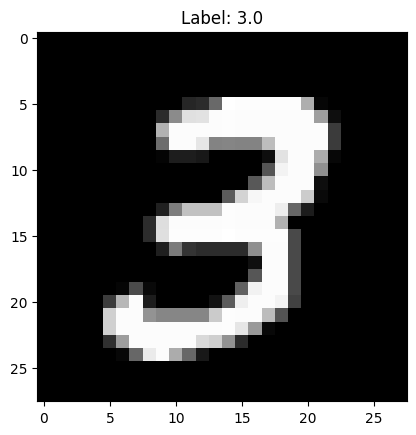

In [5]:
# Preview one of the images
import matplotlib.pyplot as plt
import numpy as np

# Select one row from the DataFrame
row = train_df.filter(train_df.id == 7).first()

# Extract the image data and label
image_data = row['features']
label = row['label']

# Convert the binary data back to a NumPy array and reshape it
image_array = np.frombuffer(image_data, dtype=np.uint8).reshape(28, 28)

# Plot the image
plt.imshow(image_array, cmap='gray')
plt.title(f'Label: {label}')
plt.show()


## Create a `DataLoader` from Delta Lake Tables
We'll create a PyTorch `DataLoader` that reads data directly from the Delta Lake format using `deltatorch`. `deltatorch` creates an iterable dataset out of the delta tables, then wraps it with a PyTorch DataLoader to enable efficient, parallel data loading into a PyTorch model. This avoids the need to convert the full Delta Lake table to Pandas/NumPy before creating the DataLoader.

In [6]:
from deltatorch import create_pytorch_dataloader
from deltatorch import FieldSpec
from utils import BinaryToFloatTensor

def create_data_loader(path:str, batch_size:int):
    return create_pytorch_dataloader(
        path,
        id_field="id",
        fields=[
            FieldSpec("features", transform=BinaryToFloatTensor()),
            FieldSpec("label"),
        ],
        num_workers=4,
        shuffle=True,
        batch_size=batch_size,
    )

train_dl = create_data_loader("./data/mnist_delta/train", batch_size=32)

Now we have a `DataLoader`:

In [8]:
type(train_dl)

torch.utils.data.dataloader.DataLoader

Now let's put the `deltatorch` `DataLoader` to work! We'll train a simple CNN on the MNIST data.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the network architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 32 * 14 * 14)  # Flatten the tensor
        x = self.fc(x)
        return x

# Create the network, loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the network
for epoch in range(2):  # Loop over the dataset multiple times
    correct = 0
    total = 0
    progress = tqdm(enumerate(train_dl), total=len(train_dl))
    for i, data in progress:
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['features'], data['label']
        inputs = inputs.unsqueeze(1).to(device)  # Add an extra dimension for the single channel (grayscale)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())  # Use long() to ensure the labels are of the correct type
        loss.backward()
        optimizer.step()
        
        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()

        if (i + 1) % 100 == 0:  # Print training accuracy every 100 batches
            acc = 100 * correct / total
            progress.set_description(f"Loss: {loss.item():.4f}, Accuracy: {acc:.2f}%")

    print(f"Epoch {epoch + 1}, Loss (Train): {loss.item():.4f}, Accuracy (Train): {acc:.2f}%")


Loss: 0.9977, Accuracy: 93.95%: : 1876it [00:31, 58.71it/s]                         

Epoch 1, Loss (Train): 0.5017, Accuracy (Train): 93.95%



Loss: 0.1571, Accuracy: 97.38%: : 1876it [00:31, 58.97it/s]                         

Epoch 2, Loss (Train): 0.1168, Accuracy (Train): 97.38%


Lastly, we'll check the accuracy on the test data.

In [10]:
test_dl = create_data_loader("./data/mnist_delta/test", batch_size=32)

test_dl = create_data_loader("./data/mnist_delta/test", batch_size=32)

# Function to calculate accuracy
def calculate_accuracy(y_pred, y_test):
    _, predicted = torch.max(y_pred, 1)
    total = y_test.size(0)
    correct = (predicted == y_test).sum().item()
    return correct / total

model.eval()  # Set the model to evaluation mode
total_accuracy = 0

with torch.no_grad():  # We don't need gradients for evaluation
    progress = tqdm(enumerate(test_dl), total=len(test_dl))
    for i, data in progress:
        inputs, labels = data['features'], data['label']
        inputs = inputs.unsqueeze(1).to(device)  # Add an extra dimension for the single channel (grayscale)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate accuracy
        acc = calculate_accuracy(outputs, labels.long())  # Use long() to ensure the labels are of the correct type
        total_accuracy += acc
        
        #progress.set_description(f"Accuracy: {acc*100:.2f}%")

# Calculate average accuracy over the entire test set
average_accuracy = total_accuracy / len(test_dl)

print(f"Average test accuracy: {average_accuracy*100:.2f}%")

316it [00:22, 14.35it/s]                          

Average test accuracy: 97.93%


For more examples, see the [examples directory in the deltatorch repository](https://github.com/delta-incubator/deltatorch/tree/main/examples).